# Fruit Classification
### Transfer learning of VGG16 model to classify fresh and rotten fruits from Kaggle dataset

### Load and prepare model for data

In [2]:
# Initial import of Keras for use throughout project
from tensorflow import keras

In [2]:
# Load base model (VGG16)
base = keras.applications.VGG16(
    weights = "imagenet", # Use imagenet weights to match
    input_shape = (224, 224, 3), # Specify input shape to match dataset (224 x 224 pixels, 3 color channels)
    include_top = False # Remove output layer
)

2023-03-26 15:49:19.506910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-26 15:49:19.507029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [3]:
# Verify removal of output layer
base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# Freeze base layers to retain learning
base.trainable = False

In [5]:
# Specify inputs with correct shape
inputs = keras.Input(shape = (224, 224, 3))
x = base(inputs, training = False)

# Add pooling layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add dense output layer
outputs = keras.layers.Dense(6, activation = "softmax")(x)

# Combine to create new model
model = keras.Model(inputs, outputs)

In [6]:
# Verify model layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# Compile the model
model.compile(
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

### Data Preparation

In [6]:
# Augment data to increase model accuracy when trained
from keras.preprocessing.image import ImageDataGenerator

# Create data generator for training dataset
datagen_train = ImageDataGenerator(
    samplewise_center = True, # Set sample mean to 0
    rotation_range = 10, # Randomly rotate images 10 degrees
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range = 0.1, # Randomly shift image horizontally
    height_shift_range = 0.1, # Randomly shift image vertically
    horizontal_flip = True, # Allow horizontal flipping
    vertical_flip = False # Don't allow vertical flipping
)

# No augmenting needed for testing data
datagen_test = ImageDataGenerator(
    samplewise_center = True # Set sample mean to 0
)

In [7]:
# Load training dataset
data_train = datagen_train.flow_from_directory(
    "dataset/train/", # Dataset path
    target_size = (224, 224), # Image size (224 x 224 pixels)
    color_mode = "rgb", # Color mode (rgb == 3 channel)
    class_mode = "categorical"
)

# Load testing dataset
data_test = datagen_test.flow_from_directory(
    "dataset/test/", # Dataset path
    target_size = (224, 224), # Image size (224 x 224 pixels)
    color_mode = "rgb", # Color mode (rgb == 3 channel)
    class_mode = "categorical"
)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


### Model Training & Fine Tuning

In [10]:
# Train & evaluate the model with training and testing datasets
model.fit(
    data_train, # Training data
    validation_data = data_test, # Testing data for validation
    steps_per_epoch = data_train.samples / data_train.batch_size, # Set steps per epoch
    validation_steps = data_test.samples / data_test.batch_size, # Set steps for validation
    epochs = 10 # Desired number of epochs for training
)

Epoch 1/10


2023-03-26 15:49:48.892425: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-26 15:49:49.249139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


341/340 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.8123

2023-03-26 15:51:26.625913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


340/340 [==============================] - 110s 320ms/step - loss: 0.6918 - accuracy: 0.8123 - val_loss: 0.1870 - val_accuracy: 0.9396
Epoch 2/10
340/340 [==============================] - 108s 318ms/step - loss: 0.1395 - accuracy: 0.9517 - val_loss: 0.0965 - val_accuracy: 0.9681
Epoch 3/10
340/340 [==============================] - 108s 317ms/step - loss: 0.0843 - accuracy: 0.9725 - val_loss: 0.0907 - val_accuracy: 0.9707
Epoch 4/10
340/340 [==============================] - 108s 318ms/step - loss: 0.0653 - accuracy: 0.9765 - val_loss: 0.0944 - val_accuracy: 0.9707
Epoch 5/10
340/340 [==============================] - 108s 318ms/step - loss: 0.0537 - accuracy: 0.9816 - val_loss: 0.0577 - val_accuracy: 0.9800
Epoch 6/10
340/340 [==============================] - 109s 319ms/step - loss: 0.0447 - accuracy: 0.9840 - val_loss: 0.0502 - val_accuracy: 0.9830
Epoch 7/10
340/340 [==============================] - 109s 319ms/step - loss: 0.0434 - accuracy: 0.9856 - val_loss: 0.0448 - val_accura

In [11]:
# Unfreeze base to fine-tune model
base.trainable = True

# Recompile model with low learning rate and unfrozen layers
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate = .00001), # Very low learning rate
    loss = "categorical_crossentropy", # Same as prior compile
    metrics = ["accuracy"] # Same as prior compile
)

In [12]:
# Train & evaluate the model with training and testing datasets
model.fit(
    data_train, # Training data
    validation_data = data_test, # Testing data for validation
    steps_per_epoch = data_train.samples / data_train.batch_size, # Set steps per epoch
    validation_steps = data_test.samples / data_test.batch_size, # Set steps for validation
    epochs = 10 # Desired number of epochs for training
)

Epoch 1/10


2023-03-26 16:11:24.382605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


341/340 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9851

2023-03-26 16:13:52.350684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


340/340 [==============================] - 161s 464ms/step - loss: 0.0473 - accuracy: 0.9851 - val_loss: 0.0294 - val_accuracy: 0.9907
Epoch 2/10
340/340 [==============================] - 157s 460ms/step - loss: 0.0153 - accuracy: 0.9958 - val_loss: 0.0140 - val_accuracy: 0.9967
Epoch 3/10
340/340 [==============================] - 157s 462ms/step - loss: 0.0116 - accuracy: 0.9968 - val_loss: 0.0146 - val_accuracy: 0.9959
Epoch 4/10
340/340 [==============================] - 157s 461ms/step - loss: 0.0093 - accuracy: 0.9980 - val_loss: 0.0129 - val_accuracy: 0.9956
Epoch 5/10
340/340 [==============================] - 157s 461ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0169 - val_accuracy: 0.9974
Epoch 6/10
340/340 [==============================] - 158s 464ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0121 - val_accuracy: 0.9974
Epoch 7/10
340/340 [==============================] - 157s 461ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0131 - val_accura

In [13]:
# Save trained model
model.save("fruit_cnn")

INFO:tensorflow:Assets written to: fruit_cnn/assets


INFO:tensorflow:Assets written to: fruit_cnn/assets


### Evaluation

In [3]:
# Load model (allows for testing without retraining)
from tensorflow import keras

reconstructed_model = keras.models.load_model("fruit_cnn")

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [4]:
# Imports for evaluation and prediction functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Create a string of characters that correspond to predictions
options = "ABOabo"

# Create a function that shows the chosen image and produces a readable string of the models prediction
def predict_fruit(image_path):
    image = mpimg.imread(image_path) # Read in image from path
    plt.imshow(image) # Display image
    image = image_utils.load_img(image_path, target_size=(224, 224)) # Load image with target size
    image = image_utils.img_to_array(image) # Convert image to numpy array
    image = image.reshape(1, 224, 224, 3) # Reshape to enure correct details for model
    image = preprocess_input(image) # Preprocess inputs for prediction
    pred = reconstructed_model.predict(image) # Predict the image using model
    prediction = options[np.argmax(pred)] # Return indices to help produce readable predictions

    # Use elif statement to produce more readable predictions for user
    if prediction == "A":
        prediction = "A Fresh Apple"
    elif prediction == "B":
        prediction = "A Fresh Banana"
    elif prediction == "O":
        prediction = "A Fresh Orange"
    elif prediction == "a":
        prediction = "A Rotten Apple"
    elif prediction == "b":
        prediction = "A Rotten Banana"
    else:
        prediction = "A Rotten Orange"

    return prediction # Return prediction

In [8]:
# Evaluate the model
reconstructed_model.evaluate(data_test, steps = data_test.samples / data_test.batch_size)

2023-03-27 10:15:30.231799: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-27 10:15:30.338255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 13s 147ms/step - loss: 0.0038 - accuracy: 0.9993


[0.0037817154079675674, 0.9992587566375732]

1/1 [==============================] - 0s 179ms/step


2023-03-27 10:15:50.756371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


'A Fresh Apple'

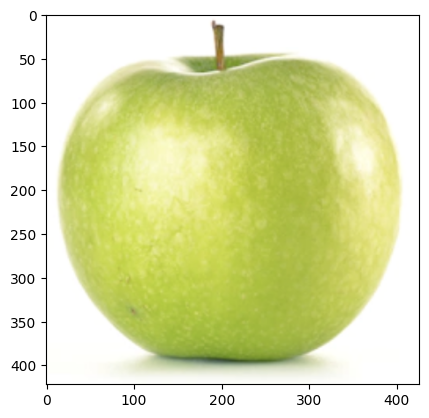

In [9]:
# Predict fruits with the predict_fruit function
predict_fruit("dataset/test/freshapples/Screen Shot 2018-06-08 at 5.03.40 PM.png")

1/1 [==============================] - 0s 14ms/step


'A Fresh Orange'

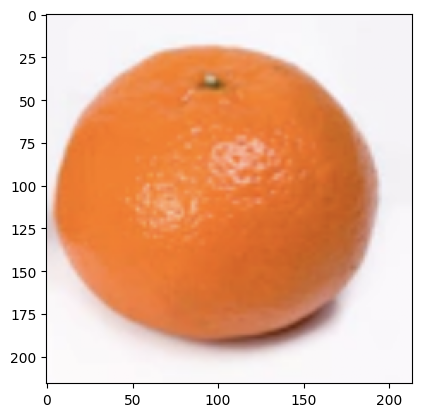

In [10]:
# Predict fruits with the predict_fruit function
predict_fruit("dataset/test/freshoranges/Screen Shot 2018-06-12 at 11.55.28 PM.png")

1/1 [==============================] - 0s 12ms/step


'A Rotten Banana'

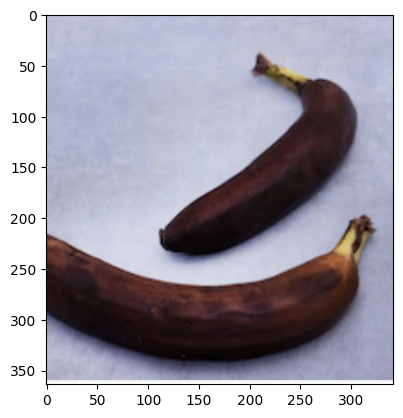

In [11]:
# Predict fruits with the predict_fruit function
predict_fruit("dataset/test/rottenbanana/Screen Shot 2018-06-12 at 8.53.09 PM.png")

1/1 [==============================] - 0s 14ms/step


'A Fresh Apple'

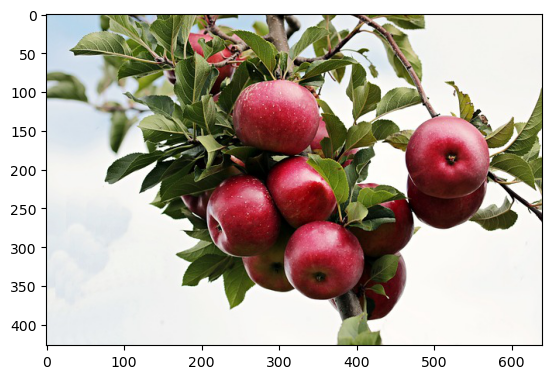

In [40]:
# Predict additional fruits with the predict_fruit function
predict_fruit("extra_fruits/freshapples/A2.jpg")

1/1 [==============================] - 0s 16ms/step


'A Fresh Orange'

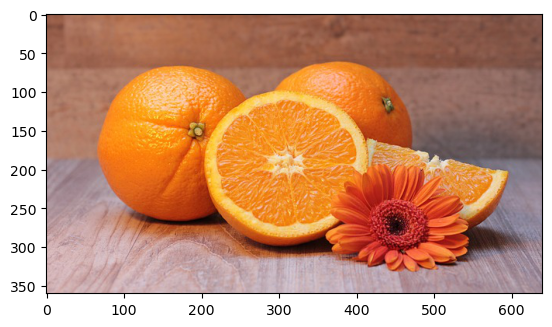

In [42]:
# Predict additional fruits with the predict_fruit function
predict_fruit("extra_fruits/freshoranges/O1.jpg")

1/1 [==============================] - 0s 15ms/step


'A Rotten Banana'

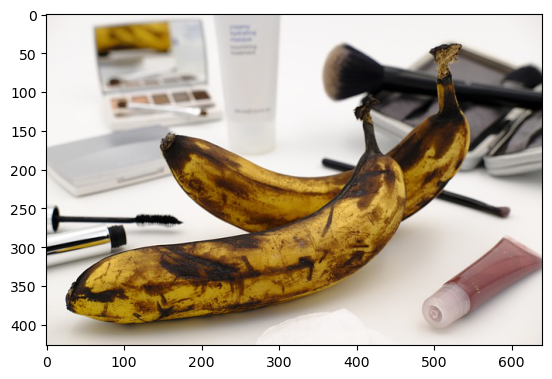

In [45]:
# Predict additional fruits with the predict_fruit function
predict_fruit("extra_fruits/rottenbananas/b2.jpg")